### **Customer Segmentation** 
#### Using Unsupervised Machine Learning Algo.
---

**Problem Definition:**  
> Identify consumer segments based on customer purchase behavior, demographic, and marketing campaign response. Targeted marketing efforts will help the company to optimize product-market fit and efficiently utilize resources.

**Stakeholders:** 
> Marketing Campaign Team, Customer base, Product Development Team, Data Analytics Team.

**Objective:** 
> Identify 4 consumer segments with descriptive insights on purchasing behavior and marketing campaign response.

**Workflow**: Python, Jupyter Notebook.
> **Modules:** Pandas, Scikit-learn, Plotnine (ggplot), Yellowbrick, Feature-engine

### 🗺 Navigate

*Exploratory Data Analysis*
* [Data Discovery](#Data-Discovery)
* [Visualization](#Visualization)

*Feature Selection*
* [Feature Engineering](#Feature-Engineering)

*Preprocessing*
* [Pipeline](#Pipeline)

*Clustering*
* [Clustering](#Clustering)

### 🥧 Dataset

The dataset is sourced from: https://www.kaggle.com/datasets/vishakhdapat/customer-segmentation-clustering
and in it contains: 
> Demographic features such as: Birth Year, Income, Age, Offspring(Kid, Teenager)

> Administrative features such as : Id, Date of Enrollment

> Purchasing Behavior such as: Recency, Purchase (Deals, Catalog, Store), Compaint, Response, Amount Spent.

#### Feature description


|Feature| Description|
|-------|------------|
| Id | Unique identifier for each individual in the dataset |
| Year_Birth | The birth year of the individual |
| Education | The highest level of education attained by the individual |
| Marital_Status | The marital status of the individual |
| Income | The annual income of the individual |
| Kidhome | The number of young children in the household |
| Teenhome | The number of teenagers in the household |
| Dt_Customer | The date when the customer was first enrolled or became a part of the company's database |
| Recency | The number of days since the last purchase or interaction |
| MntWines | The amount spent on wines |
| MntFruits | The amount spent on fruits |
| MntMeatProducts | The amount spent on meat products |
| MntFishProducts | The amount spent on fish products |
| MntSweetProducts | The amount spent on sweet products |
| MntGoldProds | The amount spent on gold products |
| NumDealsPurchases | The number of purchases made with a discount or as part of a deal |
| NumWebPurchases | The number of purchases made through the company's website |
| NumCatalogPurchases | The number of purchases made through catalogs |
| NumStorePurchases | The number of purchases made in physical stores |
| NumWebVisitsMonth | The number of visits to the company's website in a month |
| AcceptedCmp3 | Binary indicator (1 or 0) whether the individual accepted the third marketing campaign |
| AcceptedCmp4 | Binary indicator (1 or 0) whether the individual accepted the fourth marketing campaign |
| AcceptedCmp5 | Binary indicator (1 or 0) whether the individual accepted the fifth marketing campaign |
| AcceptedCmp1 | Binary indicator (1 or 0) whether the individual accepted the first marketing campaign |
| AcceptedCmp2 | Binary indicator (1 or 0) whether the individual accepted the second marketing campaign |
| Complain | Binary indicator (1 or 0) whether the individual has made a complaint |
| Z_CostContact | A constant cost associated with contacting a customer |
| Z_Revenue | A constant revenue associated with a successful campaign response |
| Response | Binary indicator (1 or 0) whether the individual responded to the marketing campaign |


#### Requirements

In [1]:
with open('requirements.txt', 'w') as t:
    t.write("yellowbrick feature_engine pingouin pyjanitor plotnine pandas numpy patchworklib")

### Import Modules

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import re
import pandas as pd
import numpy as np
from itertools import pairwise
from pandas.core.common import flatten
import janitor

import matplotlib.pyplot as plt
from plotnine import *
from mizani.formatters import *

import pingouin as pg
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import MeanMedianImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

from yellowbrick.cluster import (
    KElbowVisualizer, 
    SilhouetteVisualizer, 
    InterclusterDistance
)

from feature_engine.pipeline import Pipeline
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import OneHotEncoder

import patchworklib as pw


pd.options.display.max_columns = 30

<Figure size 100x100 with 0 Axes>

In [4]:
# plotting parameters for plotnine
COLOR = {"light_blue": "#d0e2ff", "mid_blue": "#4589ff", "dark_blue": "#0f62fe"}
CAT_COLOR = ["#1192e8", "#fa4d56", "#002d9c", "#009d9a", "#a56eff", "#005d5d", "#570408"]

# title parameters
plot_title_params = dict(size=14, family = 'Calibri', weight='normal', margin={'b': 1})

# subtitle parameters
plot_subtitle_params = dict(size=10, weight='ultralight', family='Calibri')

# text style and size parameters
custom_font_theme_params = dict(
        axis_text_x=element_text(size=7),
        axis_text_y=element_text(size=7),
        axis_title_x=element_text(size=8),
        axis_title_y=element_text(size=8),
        plot_title=element_text(**plot_title_params),
        plot_subtitle=element_text(**plot_subtitle_params))

## Data Discovery

In [6]:
# load dataframe
customer_df = pd.read_csv('customer_segmentation.csv').clean_names(case_type='snake')

In [7]:
# check first 10 entries in the dataframe
customer_df.head(10)

id  year_birth   education marital_status   income  kidhome  teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   
5  7446        1967      Master       Together  62513.0        0         1   
6   965        1971  Graduation       Divorced  55635.0        0         1   
7  6177        1985         PhD        Married  33454.0        1         0   
8  4855        1974         PhD       Together  30351.0        1         0   
9  5899        1950         PhD       Together   5648.0        1         1   

  dt_customer  recency  mnt_wines  mnt_fruits  mnt_meat_products  \
0  04-09-2012       58        635          88                546   
1  08-03-2014       38         11           1                  6   
2  21-08-2013       26        426          49                127   
3  10-02-2014       26         11           4                 20   
4  19-01-2014       94        173          43                118   
5  09-09-2013       16        520          42                 98   
6  13-11-2012       34        235          65                164   
7  08-05-2013       32         76          10                 56   
8  06-06-2013       19         14           0                 24   
9  13-03-2014       68         28           0                  6   

   mnt_fish_products  mnt_sweet_products  mnt_gold_prods  num_deals_purchases  \
0                172                  88              88                    3   
1                  2                   1               6                    2   
2                111                  21              42                    1   
3                 10                   3               5                    2   
4                 46                  27              15                    5   
5                  0                  42              14                    2   
6                 50                  49              27                    4   
7                  3                   1              23                    2   
8                  3                   3               2                    1   
9                  1                   1              13                    1   

   num_web_purchases  num_catalog_purchases  num_store_purchases  \
0                  8                     10                    4   
1                  1                      1                    2   
2                  8                      2                   10   
3                  2                      0                    4   
4                  5                      3                    6   
5                  6                      4                   10   
6                  7                      3                    7   
7                  4                      0                    4   
8                  3                      0                    2   
9                  1                      0                    0   

   num_web_visits_month  accepted_cmp3  accepted_cmp4  accepted_cmp5  \
0                     7              0              0              0   
1                     5              0              0              0   
2                     4              0              0              0   
3                     6              0              0              0   
4                     5              0              0              0   
5                     6              0              0              0   
6                     6              0              0              0   
7                     8              0              0              0   
8                     9              0              0              0   
9                    20             

#### Missing Data

In [8]:
customer_df.isna().sum()

id                        0
year_birth                0
education                 0
marital_status            0
income                   24
kidhome                   0
teenhome                  0
dt_customer               0
recency                   0
mnt_wines                 0
mnt_fruits                0
mnt_meat_products         0
mnt_fish_products         0
mnt_sweet_products        0
mnt_gold_prods            0
num_deals_purchases       0
num_web_purchases         0
num_catalog_purchases     0
num_store_purchases       0
num_web_visits_month      0
accepted_cmp3             0
accepted_cmp4             0
accepted_cmp5             0
accepted_cmp1             0
accepted_cmp2             0
complain                  0
z_cost_contact            0
z_revenue                 0
response                  0
dtype: int64

In [9]:
customer_df[customer_df.isna().any(axis=1)]

id  year_birth   education marital_status  income  kidhome  teenhome  \
10     1994        1983  Graduation        Married     NaN        1         0   
27     5255        1986  Graduation         Single     NaN        1         0   
43     7281        1959         PhD         Single     NaN        0         0   
48     7244        1951  Graduation         Single     NaN        2         1   
58     8557        1982  Graduation         Single     NaN        1         0   
71    10629        1973    2n Cycle        Married     NaN        1         0   
90     8996        1957         PhD        Married     NaN        2         1   
91     9235        1957  Graduation         Single     NaN        1         1   
92     5798        1973      Master       Together     NaN        0         0   
128    8268        1961         PhD        Married     NaN        0         1   
133    1295        1963  Graduation        Married     NaN        0         1   
312    2437        1989  Graduation        Married     NaN        0         0   
319    2863        1970  Graduation         Single     NaN        1         2   
1379  10475        1970      Master       Together     NaN        0         1   
1382   2902        1958  Graduation       Together     NaN        1         1   
1383   4345        1964    2n Cycle         Single     NaN        1         1   
1386   3769        1972         PhD       Together     NaN        1         0   
2059   7187        1969      Master       Together     NaN        1         1   
2061   1612        1981         PhD         Single     NaN        1         0   
2078   5079        1971  Graduation        Married     NaN        1         1   
2079  10339        1954      Master       Together     NaN        0         1   
2081   3117        1955  Graduation         Single     NaN        0         1   
2084   5250        1943      Master          Widow     NaN        0         0   
2228   8720        1978    2n Cycle       Together     NaN        0         0   

     dt_customer  recency  mnt_wines  mnt_fruits  mnt_meat_products  \
10    15-11-2013       11          5           5                  6   
27    20-02-2013       19          5           1                  3   
43    05-11-2013       80         81          11                 50   
48    01-01-2014       96         48           5                 48   
58    17-06-2013       57         11           3                 22   
71    14-09-2012       25         25           3                 43   
90    19-11-2012        4        230          42                192   
91    27-05-2014       45          7           0                  8   
92    23-11-2013       87        445          37                359   
128   11-07-2013       23        352           0                 27   
133   11-08-2013       96        231          65                196   
312   03-06-2013       69        861         138                461   
319   23-08-2013       67        738          20                172   
1379  01-04-2013       39        187           5                 65   
1382  03-09-2012       87         19           4                 12   
1383  12-01-2014       49          5           1                  9   
1386  02-03-2014       17         25           1                 13   
2059  18-05-2013       52        375          42                 48   
2061  31-05-2013       82         23           0                 15   
2078  03-03-2013       82         71           1                 16   
2079  23-06-2013       83        161           0                 22   
2081  18-10-2013       95        264           0                 21   
2084  30-10-2013       75        532         126                490   
2228  12-08-2012       53         32           2               1607   

      mnt_fish_products  mnt_sweet_products  mnt_gold_prods  \
10                    0                   2               1   
27                    3                 263             362   
43                

#### Duplicated Unique Features and Entries

In [10]:
# are there duplicated customer ids?
customer_df.id.duplicated().value_counts()

id
False    2240
Name: count, dtype: int64

In [11]:
customer_df[customer_df.duplicated()]

Empty DataFrame
Columns: [id, year_birth, education, marital_status, income, kidhome, teenhome, dt_customer, recency, mnt_wines, mnt_fruits, mnt_meat_products, mnt_fish_products, mnt_sweet_products, mnt_gold_prods, num_deals_purchases, num_web_purchases, num_catalog_purchases, num_store_purchases, num_web_visits_month, accepted_cmp3, accepted_cmp4, accepted_cmp5, accepted_cmp1, accepted_cmp2, complain, z_cost_contact, z_revenue, response]
Index: []

### Visualization
---

#### Year Birth

In [12]:
# aggregate count of the year of birth
year_birth_df = customer_df\
    .year_birth\
    .value_counts()\
    .reset_index()

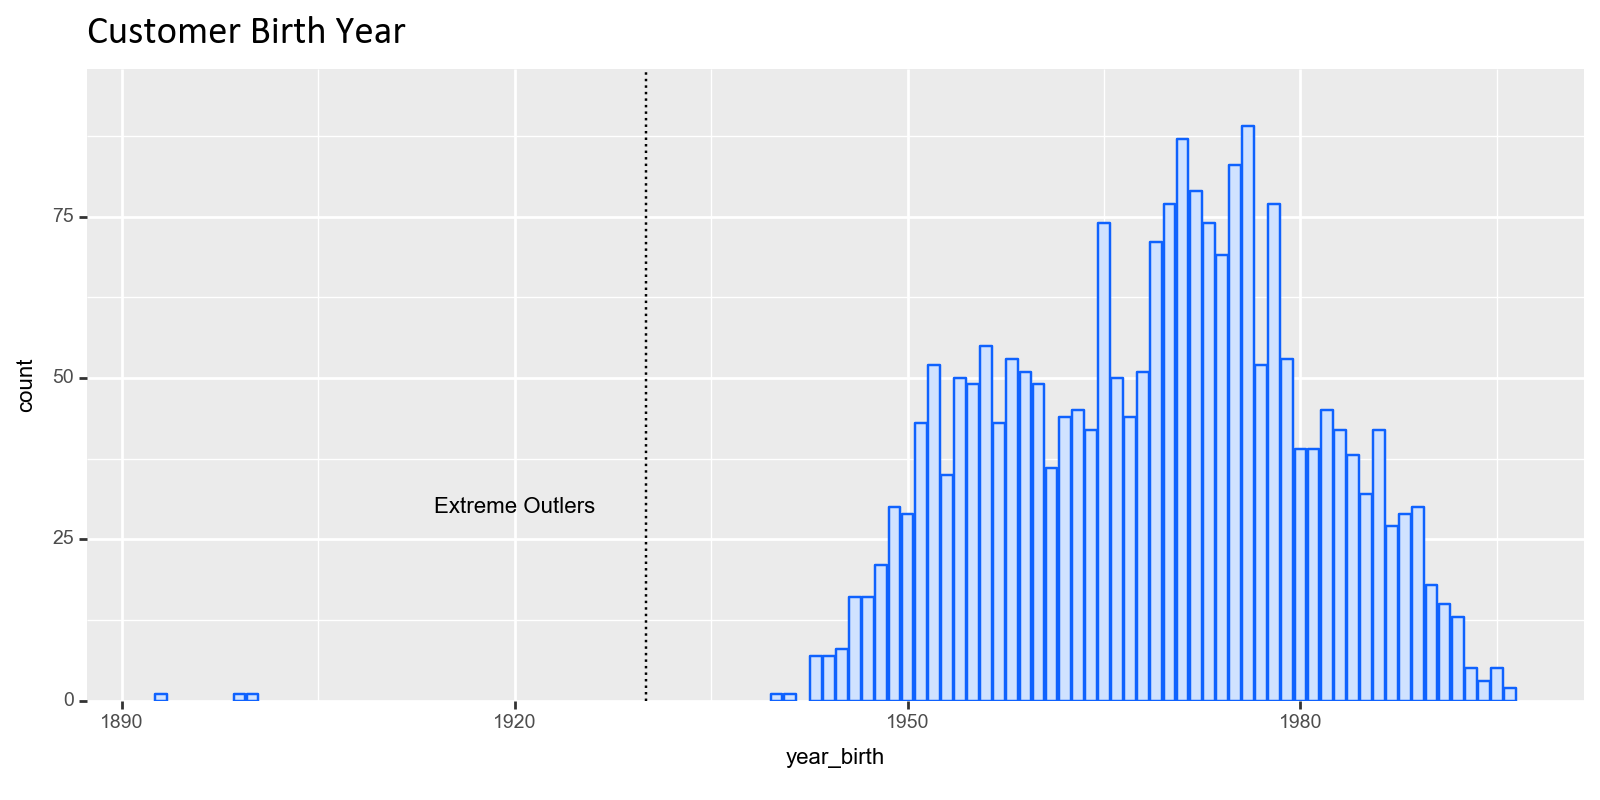

In [122]:
# create birth year count col plot
year_birth_plot = ggplot(year_birth_df, aes('year_birth', 'count'))\
    + geom_col(color=COLOR['dark_blue'], fill=COLOR['light_blue'])\
    + scale_y_continuous(expand=(0, 0, 0.1, 0))\
    + theme(figure_size=(8, 4), **custom_font_theme_params)\
    + labs(title='Customer Birth Year')\
    + geom_vline(xintercept=1930, linetype='dotted')\
    + annotate('text', x=1920, y=30, label='Extreme Outlers', size=8)

year_birth_plot.draw()

#### Education & Income

In [14]:
# set education as categorical dtype (for plotting)
education_df = customer_df.copy()[['id', 'education']]
education_df['education'] = pd.Categorical(
    education_df['education'],
    categories=education_df.education.value_counts().reset_index().education.tolist(),
    ordered=True)

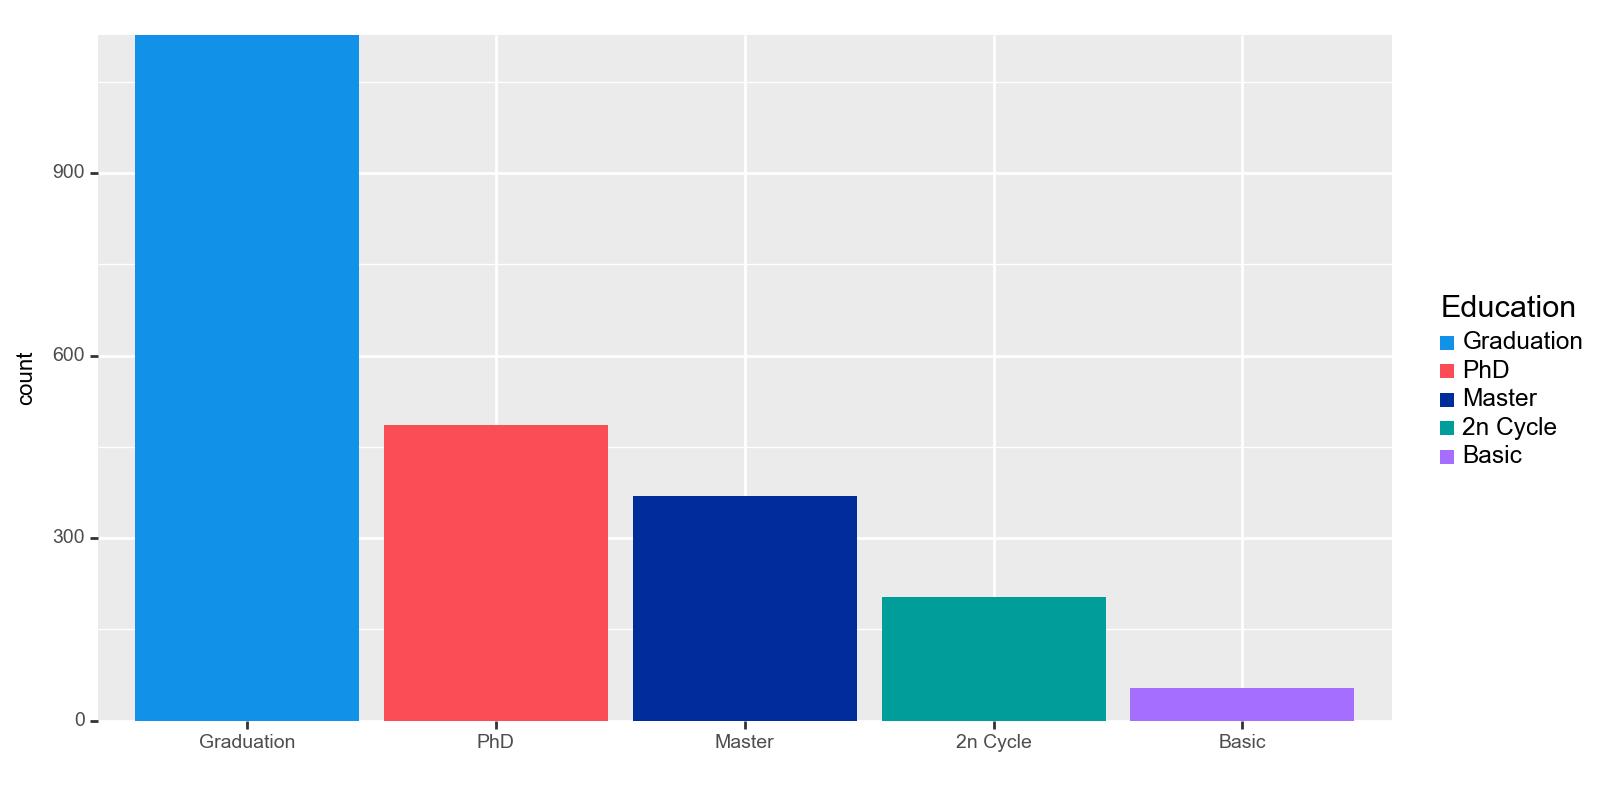

In [127]:
# create education plot
education_bar_plot = ggplot(education_df)\
    + geom_bar(aes('factor(education)', fill='factor(education)'))\
    + scale_fill_manual(CAT_COLOR)\
    + scale_y_continuous(expand=(0, 0))\
    + labs(fill='Education', x='')\
    + theme(legend_key_size=5, **custom_font_theme_params, figure_size=(8, 4))

education_bar_plot.draw()

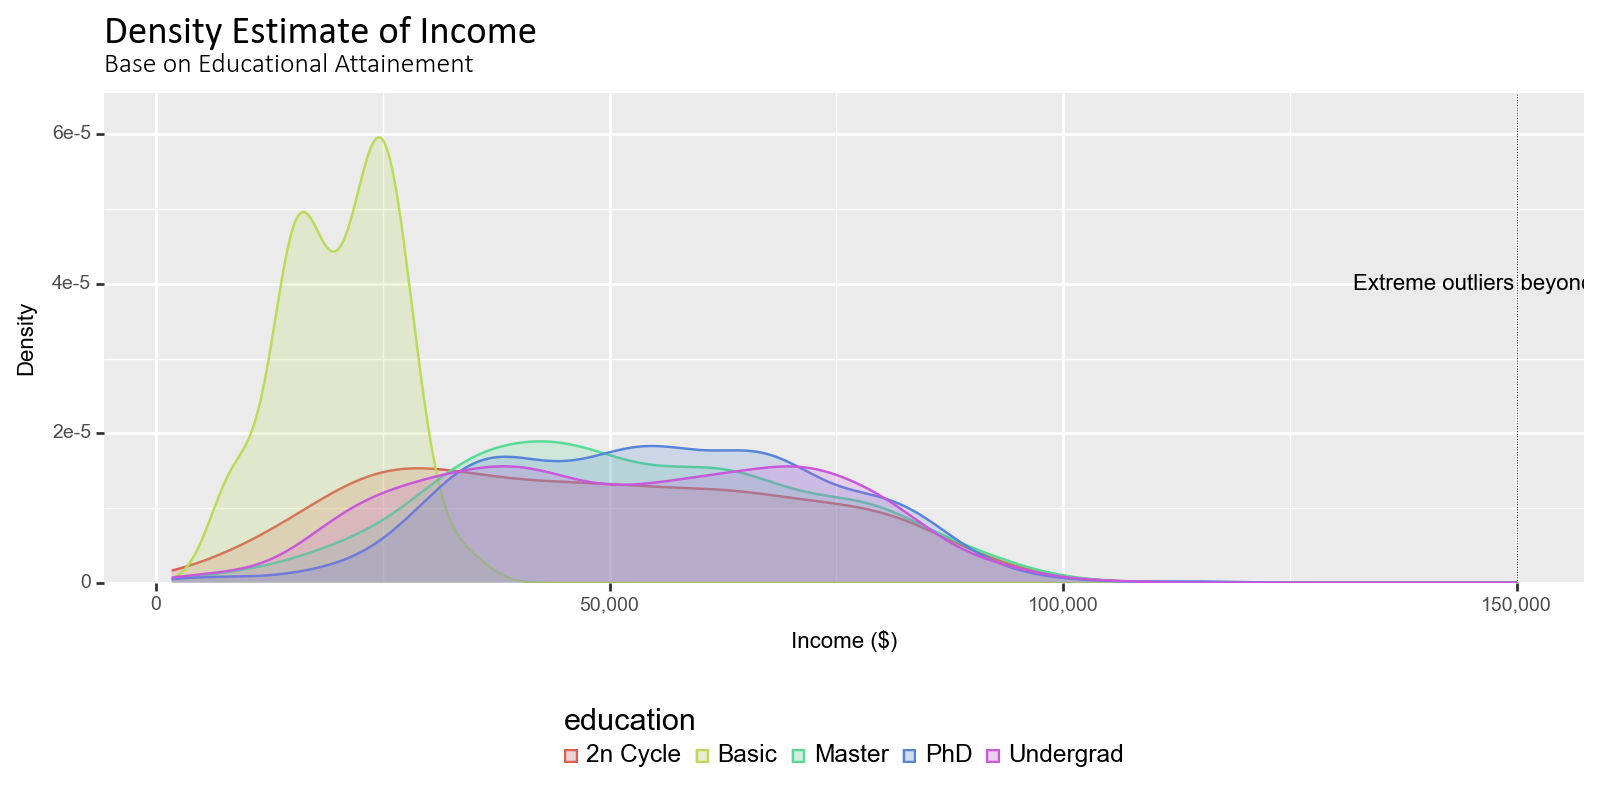

In [125]:
# create income kernel density plot
customer_income_density_plot = ggplot(customer_df, aes('income', color='education', fill='education'))\
    + geom_density(alpha=.2)\
    + scale_y_continuous(expand=(0, 0, 0.1, 0))\
    + scale_x_continuous(labels=comma_format())\
    + theme(figure_size=(8, 4), **custom_font_theme_params, legend_position='bottom', legend_key_size=5)\
    + labs(x='Income ($)', y='Density', title='Density Estimate of Income', subtitle='Base on Educational Attainement')\
    + geom_vline(xintercept=150_000, size=.2, linetype='dotted')\
    + annotate('text', x=150_000, y=4e-5, label='Extreme outliers beyond this line.', size=8)

customer_income_density_plot.draw()

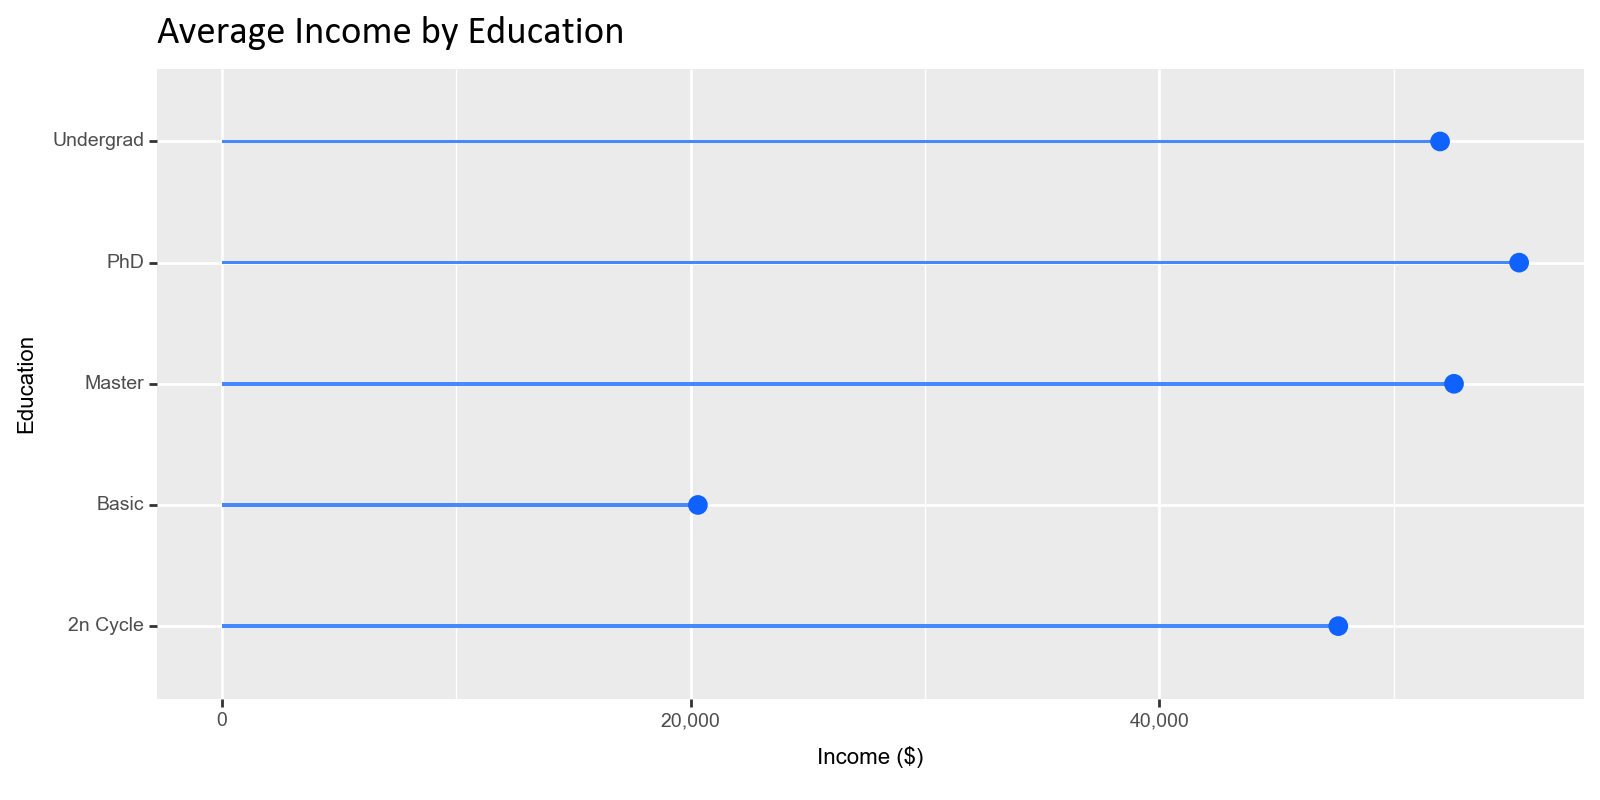

In [126]:
# create average by education
education_income_df = customer_df.groupby(['education']).agg({'income': 'mean'}).reset_index()
education_income_plot = ggplot(education_income_df, aes('education', 'income'))\
    + geom_col(width=0.03, fill=COLOR['mid_blue'])\
    + geom_point(size=3, fill=COLOR['dark_blue'], color=COLOR['dark_blue'])\
    + theme(figure_size=(8, 4), **custom_font_theme_params)\
    + scale_y_continuous(labels=comma_format())\
    + coord_flip()\
    + labs(x='Education', y='Income ($)', title='Average Income by Education')

education_income_plot.draw()

### Distribution & Normality

#### Shaprio-Wilk Test for Normality and Outlier Detection

In [18]:
# select numerical features from our customer dataframe
normality_test_df = customer_df\
    .select_dtypes('number')\
    .drop(['id', 'year_birth'], axis=1)

In [19]:
# use pingouin normality test (shapiro-wilk test)
normality_test_df_results = pg.normality(normality_test_df)

# format boolean 
normality_test_df_results.style.applymap(
    lambda x: f"""background-color: {COLOR['dark_blue']}""" if x \
        else f"""background-color: {COLOR['light_blue']}""", subset='normal'
)

## Feature Engineering
---

#### Birth Year (Numerical Type) to Generation (Discrete)

In [20]:
# create a mapping function for our year-birth column
def generation_mapping(year: int) -> str:
    """
    A mapper for customer dataframe `year_birth` column.
    :returns: A descriptive label for year of birth base on birth generation.
    :return type: String
    """
    
    if 1883 <= year <= 1900:
        return 'Lost Generation'
        
    elif 1901 <= year <= 1924:
        return 'Greatest Generation'
        
    elif 1925 <= year <= 1945:
        return 'Silent Generation'
        
    elif 1946 <= year <= 1964:
        return 'Baby Boomer Generation'
        
    elif 1965 <= year <= 1980:
        return 'Generation X'
        
    elif 1981 <= year <= 1996:
        return 'Generation Y'

In [21]:
# transform birth generation to our own mapping
customer_df['birth_generation'] = customer_df['year_birth'].apply(generation_mapping)

#### Reduce cardinality for Marital Status

In [22]:
# check for the unique values in marital status
customer_df.marital_status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [23]:
# select non-formal and low frequency values by getting their index
index_to_drop = customer_df[customer_df.marital_status.isin(['Alone', 'Absurd', 'YOLO'])].index

# drop them directly to our customer dataframe
customer_df = customer_df.drop(index_to_drop)

#### Correlation of Amount & Number of purchases

In [24]:
# select columns with col names beginning with mnt and num
amount_freq_df = pd.concat([
    customer_df.select_columns('mnt*'),
    customer_df.select_columns('num*')
], axis=1)

In [25]:
# perform a pearson correlation and style the table
amount_freq_df.corr().style.background_gradient(cmap='Greys')

#### Change Education "Graduation" to "Undergrad"

In [26]:
# Graduation is vague so we replace it with undergraduate (college)
customer_df['education'] = customer_df.education.str.replace('Graduation', 'Undergrad')

#### Remove Income Outliers

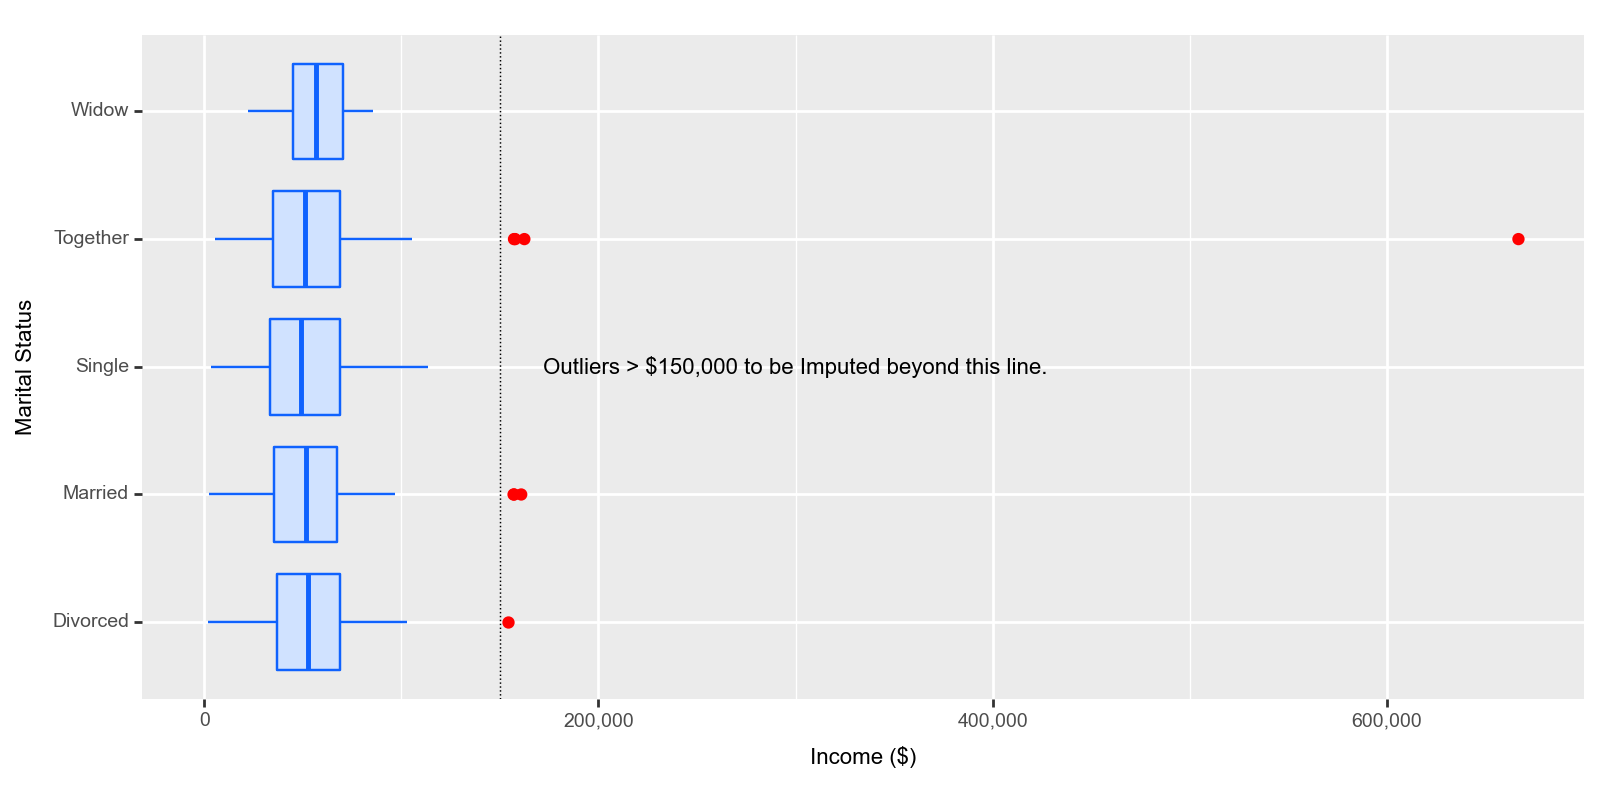

In [27]:
# create a boxplot to see outliers
outliers_plot = ggplot(customer_df, aes('marital_status', 'income'))\
    + geom_boxplot(fill=COLOR['light_blue'], color=COLOR['dark_blue'], outlier_color='red')\
    + geom_hline(yintercept=150_000, size=.3, linetype='dotted')\
    + annotate('text', x=3, y=300_000, size=8, label='Outliers > $150,000 to be Imputed beyond this line.')\
    + coord_flip()\
    + theme(**custom_font_theme_params, figure_size=(8, 4))\
    + labs(x='Marital Status', y='Income ($)')\
    + scale_y_continuous(labels=comma_format())

outliers_plot.draw()

In [28]:
# we get the index of values greater or equal to 150,000
index_to_drop = customer_df[customer_df.income >= 150_000].index

# drop these index directly to our customer dataframe
customer_df = customer_df.drop(index_to_drop)

## Pipeline
---

In [30]:
# exclude these features in our training
exclude_cols = ['id', 'year_birth']

# drop the columns and convert dt feature before transformation
train_df = customer_df\
    .drop(exclude_cols, axis=1)\
    .to_datetime('dt_customer', format='%d-%m-%Y')

In [31]:
# select categorical feature names to be encoded
to_encode_features = train_df.select_dtypes('object').columns.tolist()

In [32]:
# Prepare transformers for pipeline
# Standard Scaler for scaling our numerical features
scaler = SklearnTransformerWrapper(StandardScaler())

# Encoder for our categorical Features
ohe = OneHotEncoder(variables=to_encode_features)

# Expand on customer date of acquiantance.
dtf = DatetimeFeatures(
    variables='dt_customer',
    features_to_extract=['month', 'year', 'day_of_year'])

# Imputer for our income feature
mmi = MeanMedianImputer(variables='income', imputation_method='median')

In [33]:
# create pipeline along with naming each step
pipe = Pipeline([
    ('dt-feature', dtf),
    ('median-imputer', mmi),
    ('scaler', scaler),
    ('ohe', ohe)
]).fit(train_df)

In [34]:
# transform our train dataframe
output_df = pipe.transform(train_df)
output_df.head(10)

income   kidhome  teenhome   recency  mnt_wines  mnt_fruits  \
0  0.315984 -0.825313 -0.930734  0.304899   0.978943    1.547525   
1 -0.256214  1.031432  0.905155 -0.386042  -0.872326   -0.637370   
2  0.969736 -0.825313 -0.930734 -0.800607   0.358887    0.568090   
3 -1.211882  1.031432 -0.930734 -0.800607  -0.872326   -0.562028   
4  0.323504  1.031432 -0.930734  1.548594  -0.391708    0.417407   
5  0.528241 -0.825313  0.905155 -1.146078   0.637764    0.392293   
6  0.194548 -0.825313  0.905155 -0.524230  -0.207768    0.969909   
7 -0.881585  1.031432 -0.930734 -0.593325  -0.679485   -0.411346   
8 -1.032130  1.031432 -0.930734 -1.042437  -0.863425   -0.662483   
9 -2.230620  1.031432  0.905155  0.650370  -0.821890   -0.662483   

   mnt_meat_products  mnt_fish_products  mnt_sweet_products  mnt_gold_prods  \
0           1.733637           2.466263            1.470077        0.844670   
1          -0.726574          -0.652442           -0.633534       -0.731194   
2          -0.175305           1.347198           -0.149945       -0.039351   
3          -0.662791          -0.505680           -0.585175       -0.750412   
4          -0.216308           0.154752           -0.004868       -0.558233   
5          -0.307427          -0.689133            0.357823       -0.577451   
6          -0.006735           0.228133            0.527079       -0.327619   
7          -0.498777          -0.634097           -0.633534       -0.404490   
8          -0.644567          -0.634097           -0.585175       -0.808065   
9          -0.726574          -0.670788           -0.633534       -0.596669   

   num_deals_purchases  num_web_purchases  num_catalog_purchases  \
0             0.362118           1.408817               2.636134   
1            -0.165872          -1.116191              -0.585629   
2            -0.693861           1.408817              -0.227655   
3            -0.165872          -0.755476              -0.943602   
4             1.418097           0.326670               0.130319   
5            -0.165872           0.687386               0.488292   
6             0.890107           1.048101               0.130319   
7            -0.165872          -0.034045              -0.943602   
8            -0.693861          -0.394760              -0.943602   
9            -0.693861          -1.116191              -0.943602   

   num_store_purchases  num_web_visits_month  ...  education_Undergrad  \
0            -0.557708              0.691368  ...                    1   
1            -1.173997             -0.137231  ...                    1   
2             1.291162             -0.551530  ...                    1   
3            -0.557708              0.277069  ...                    1   
4             0.058582             -0.137231  ...                    0   
5             1.291162              0.277069  ...                    0   
6             0.366727              0.277069  ...                    1   
7            -0.557708              1.105667  ...                    0   
8            -1.173997              1.519967  ...                    0   
9            -1.790287              6.077260  ...                    0   

   education_PhD  education_Master  education_Basic  education_2n Cycle  \
0              0                 0                0                   0   
1              0                 0                0                   0   
2              0                 0                0                   0   
3              0                 0                0                   0   
4              1                 0                0                   0   
5              0                 1                0                   0   
6              0                 0                0                   0   
7              1                 0                0                   0   
8              1                 0                0                   0   
9              1                 0                0                   0 

## Clustering

In [36]:
# create kmeans model with clusters of 6
km = KMeans(n_clusters=6, random_state=25)

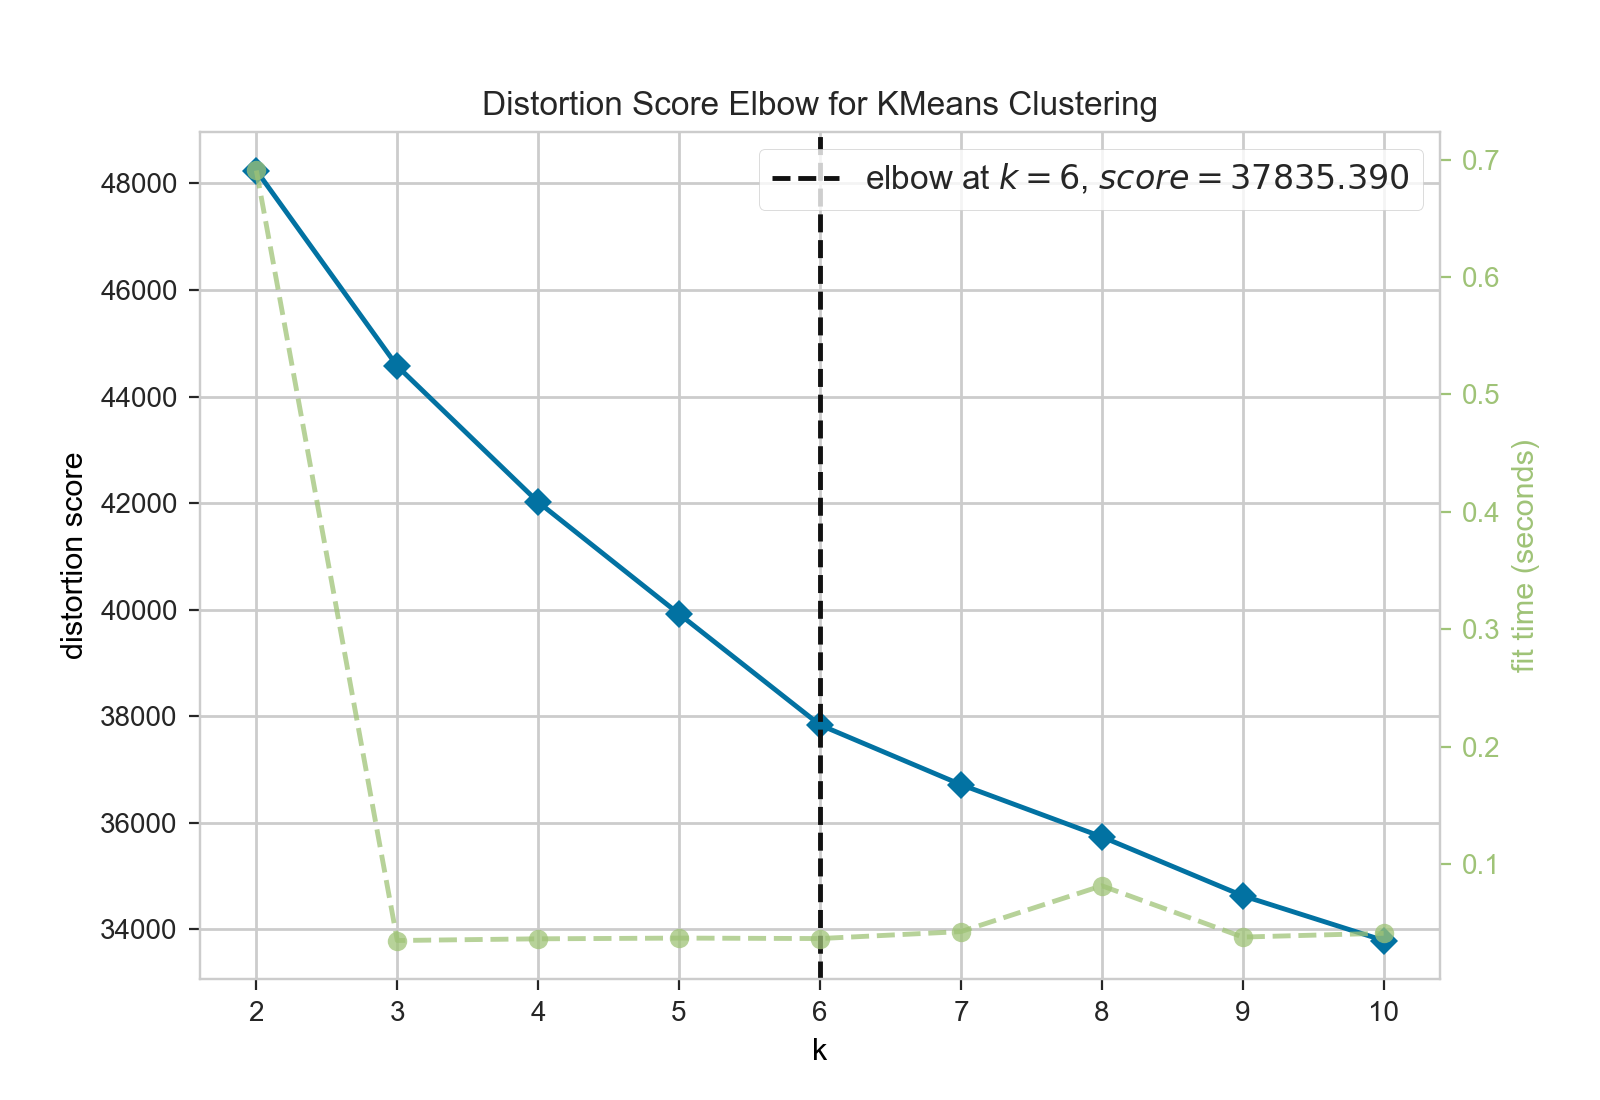

In [37]:
# visualize using elbow method which uses Within-Cluster-Sum of Squared Errors (WSS)
visualizer = KElbowVisualizer(km).fit(output_df)
visualizer.show();

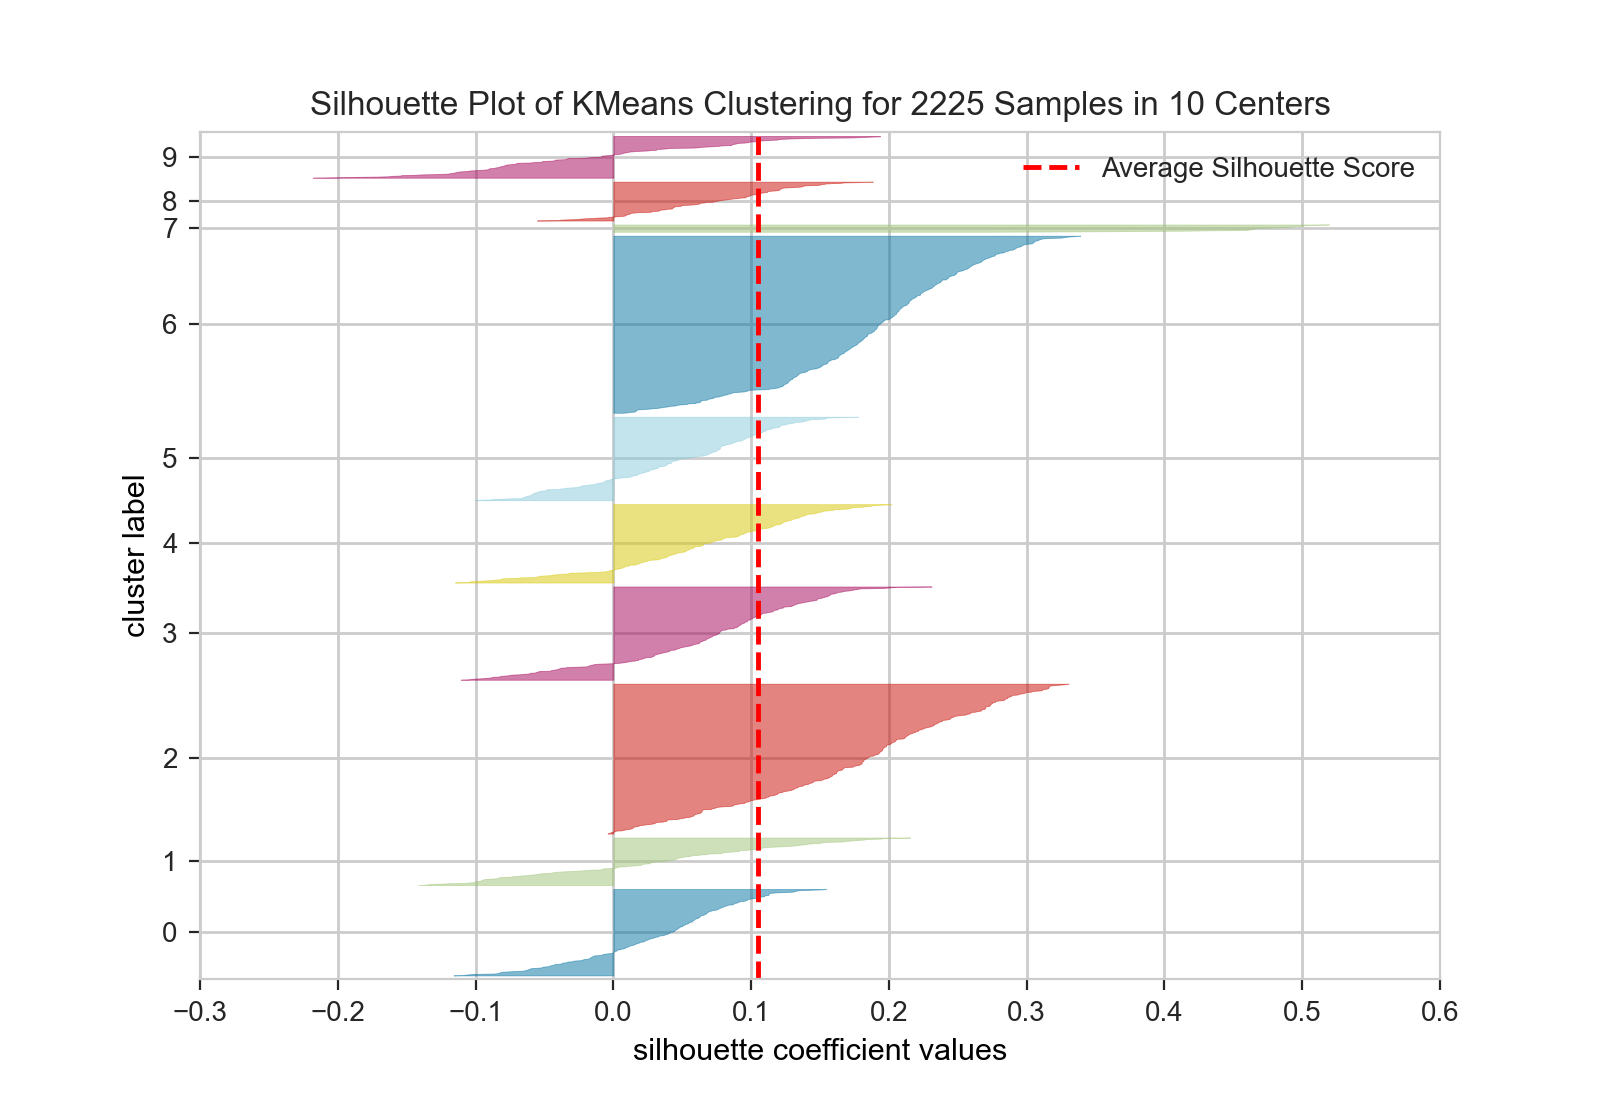

In [38]:
# Visualize silhouette score
sil = SilhouetteVisualizer(km, colors='yellowbrick').fit(output_df)
sil.show();

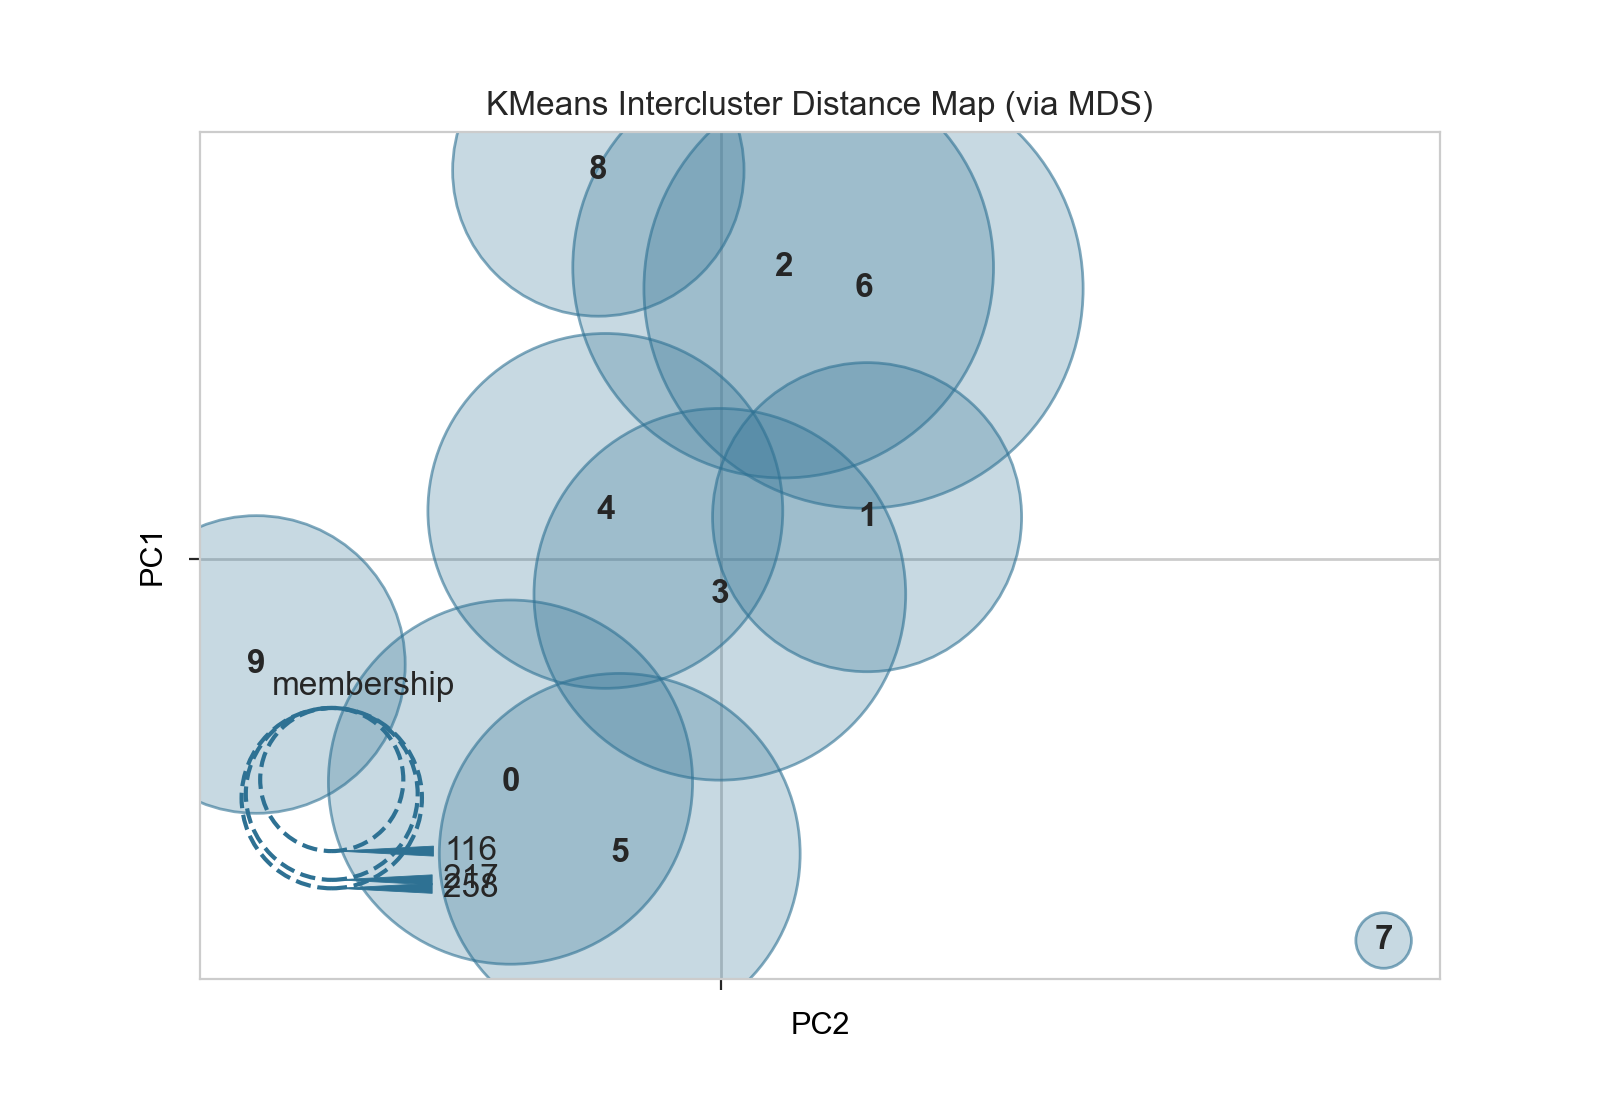

In [128]:
# visualize intercluster distance
icd_viz = InterclusterDistance(km)
icd_viz.fit(output_df)
icd_viz.show();

#### Hierarchical Clustering

In [41]:
# create linkage
h_cluster = linkage(output_df, method='ward')

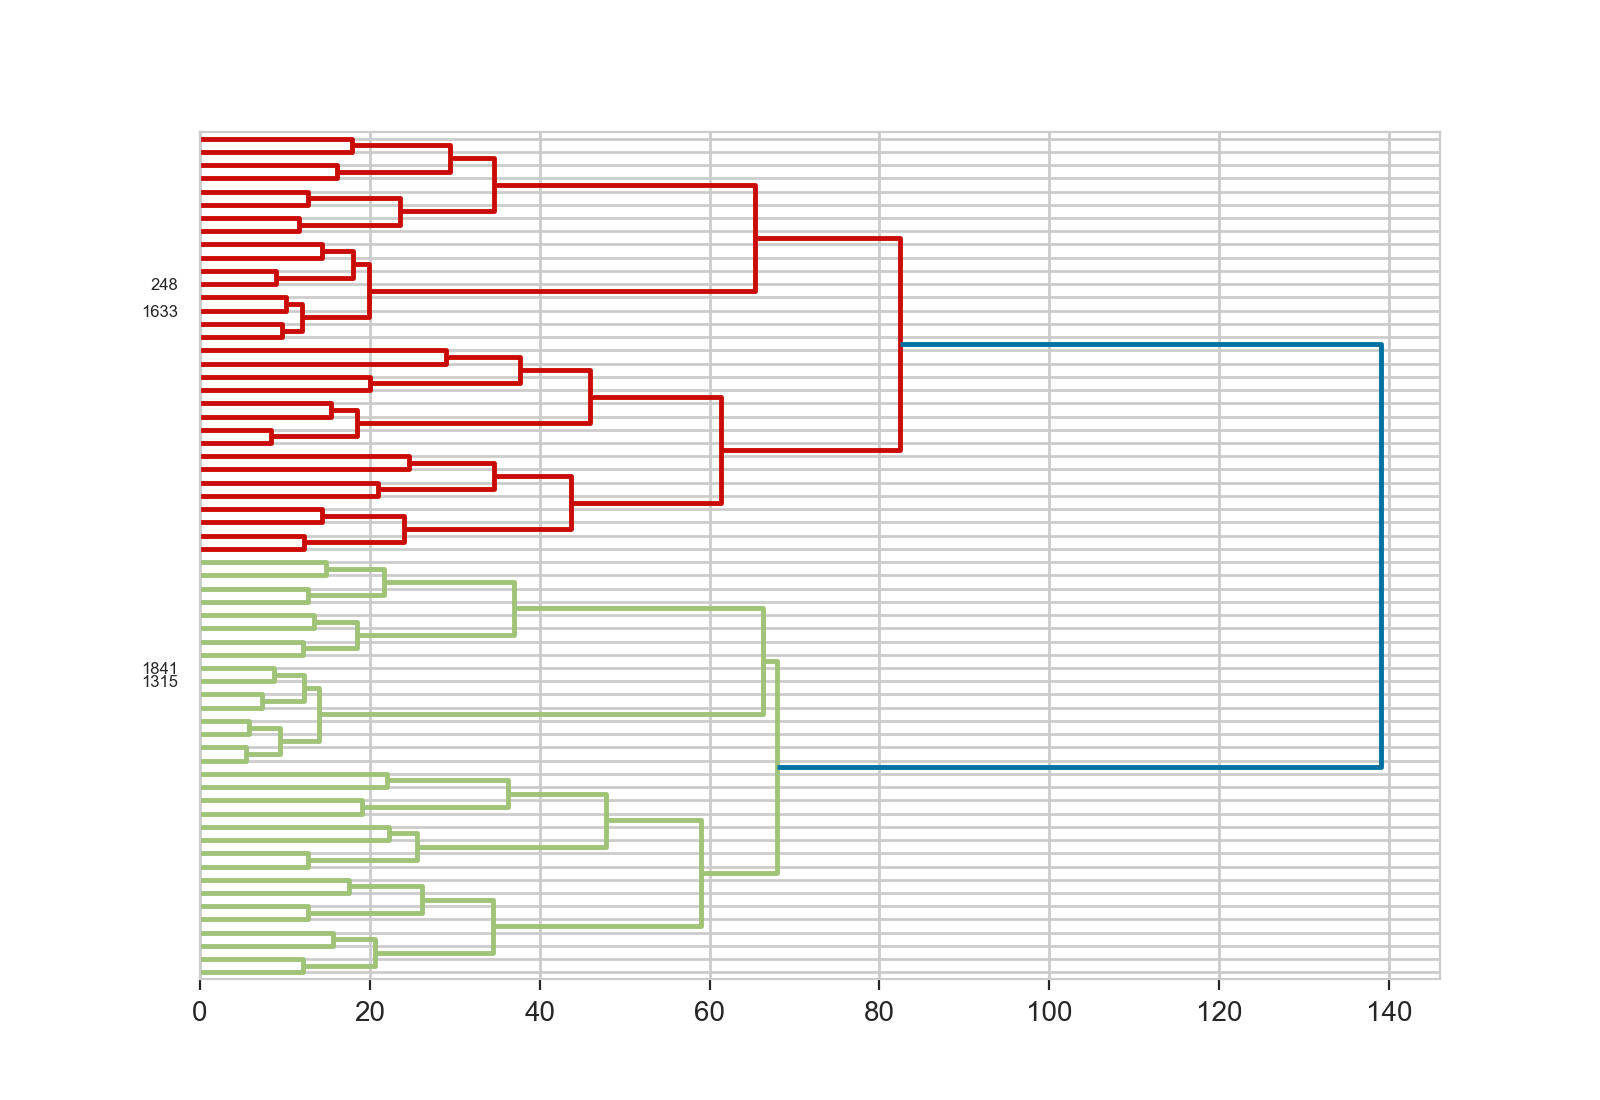

In [42]:
# visualize using dendogram
dendrogram(h_cluster, show_leaf_counts=False, orientation='right', truncate_mode='level', p=5)
plt.show()

#### Segmentation

In [80]:
class PatchGrid:
    """
    Naive Class to Plot our features in a grid.
    """
    def __init__(self, patchwork_list: list, grid: tuple):
        
        self.patchwork = patchwork_list
        self.size = len(patchwork_list)
        self.structure = None
        self.plotted_structure = None
        self.grid = grid
        self._post_init()

    def _post_init(self):
        self.structure_grid()
        self.insert_plots_to_structure()

    def structure_grid(self) -> None:
        """
        Create a structured syntax of a patch based on patchworklib. 
        :return type: None
        """
        
        self.structure = ""
        row_composition = []
        row: int = self.grid[0]
        col: int = self.grid[1]
        total_rows = 1
        
        # check if total grid is divisible with no remainder
        if self.size % 2 == 0:

            # for loop on the number of rows needed based on given grid
            for nrows in np.arange(row, dtype=int):

                # a concatendated string that follows the syntax for patching using pipes and slash
                _row: str = "(" + (self.structure + '{p}|' * row).rstrip('|') + ")" + "/"

                # a boolean state to check if we are in the end of the row
                end_of_row: bool = total_rows == self.grid[0]
                
                if not end_of_row:
                    row_composition.append([_row])                    
                else:
                    # if we are at the end we remove '/' as it is not needed
                    row_composition.append([_row.rstrip('/')])
                
                total_rows += 1

        # flatten our structure since it's currently nested list
        flatten_structure: list = [i for i in flatten(row_composition)]

        # join elements in a list into a single line of string
        string_flatten_structure: str = ''.join(flatten_structure)

        # assign it to our class attribute
        self.structure: str = string_flatten_structure

    def insert_plots_to_structure(self):
        series_structure = pd.Series([self.structure], name='structure').str.split('}', expand=True)
        patches = []
        
        for count, i in enumerate(series_structure.iloc[0]):
            patch_string = i.replace('p', f'self.patchwork[{count}]').replace('{', '')
            patches.append(patch_string)
            
        # clean_patches = [i + '}' for i in patches]
        self.plotted_structure = ''.join(patches)
        
    def show(self):
        return eval(f'{self.plotted_structure}')

In [119]:
def make_ggplot_patch(dataframe: pd.DataFrame, cols_to_pair: list[str])\
    -> PatchGrid:
        
    ggplot_point_plots = []
    for i in pairwise(cols_to_pair):
        p = ggplot(dataframe)\
            + geom_point(aes(i[0], i[1], fill='factor(segments)'), alpha=.3)\
            + labs(fill='Segments')\
            + scale_fill_manual(CAT_COLOR)\
            + theme(
                **custom_font_theme_params, 
                legend_title=element_text(size=8),
                axis_line=element_line(color='black'),
                panel_grid_minor=element_line(color='gray', size=.2),
                panel_grid_major=element_line(color='gray', size=.2),)
        
        patch = pw.load_ggplot(p, figsize=(4, 2))
        ggplot_point_plots.append(patch)
    
    patch_grid = PatchGrid(ggplot_point_plots, grid=(4, 4))
    return patch_grid

In [43]:
km_clusters6 = KMeans(n_clusters=2, random_state=25)
labels = km_clusters6.fit_predict(output_df)

In [44]:
seg_df = output_df.copy()
seg_df['segments'] = labels

In [46]:
demographic = seg_df.select_columns(
    'income', 
    'kidhome',
    'teenhome',
    'education*', 
    'marital_status*', 
    'birth_generation*',
    'segments'
)

In [47]:
demographic.filter_on('segments == 0').describe()

income     kidhome    teenhome  education_Undergrad  education_PhD  \
count  881.000000  881.000000  881.000000           881.000000     881.000000   
mean     0.950027   -0.703075   -0.147199             0.531215       0.232690   
std      0.581204    0.469146    0.981517             0.499308       0.422786   
min     -2.385920   -0.825313   -0.930734             0.000000       0.000000   
25%      0.592670   -0.825313   -0.930734             0.000000       0.000000   
50%      0.961052   -0.825313   -0.930734             1.000000       0.000000   
75%      1.358786   -0.825313    0.905155             1.000000       0.000000   
max      3.013278    2.888177    2.741044             1.000000       1.000000   

       education_Master  education_Basic  education_2n Cycle  \
count        881.000000       881.000000          881.000000   
mean           0.149830         0.001135            0.085131   
std            0.357107         0.033691            0.279234   
min            0.000000         0.000000            0.000000   
25%            0.000000         0.000000            0.000000   
50%            0.000000         0.000000            0.000000   
75%            0.000000         0.000000            0.000000   
max            1.000000         1.000000            1.000000   

       marital_status_Single  marital_status_Together  marital_status_Married  \
count             881.000000               881.000000              881.000000   
mean                0.214529                 0.257662                0.368899   
std                 0.410728                 0.437595                0.482781   
min                 0.000000                 0.000000                0.000000   
25%                 0.000000                 0.000000                0.000000   
50%                 0.000000                 0.000000                0.000000   
75%                 0.000000                 1.000000                1.000000   
max                 1.000000                 1.000000                1.000000   

       marital_status_Divorced  marital_status_Widow  \
count               881.000000            881.000000   
mean                  0.114642              0.044268   
std                   0.318771              0.205806   
min                   0.000000              0.000000   
25%                   0.000000              0.000000   
50%                   0.000000              0.000000   
75%                   0.000000              0.000000   
max                   1.000000              1.000000   

       birth_generation_Baby Boomer Generation  birth_generation_Generation X  \
count                               881.000000                     881.000000   
mean                                  0.405221                       0.414302   
std                                   0.491214                       0.492881   
min                                   0.000000                       0.000000   
25%                                   0.000000                       0.000000   
50%                                   0.000000                       0.000000   
75%                                   1.000000                       1.000000   
max                                   1.000000                       1.000000   

       birth_generation_Generation Y  birth_generation_Silent Generation  \
count                     881.000000                          881.000000   
mean                        0.155505                            0.023837   
std                         0.362591                            0.152626   
min                         0.000000                            0.000000   
25%                         0.000000                            0.000000   
50%                         0.000000                            0.000000   
75%                         0.000000                            0.000000   
max                         1.000000                            1.000000   

       birth_generation_Lost Generation  segments  
co

In [48]:
demographic.filter_on('segments == 1').describe()

income      kidhome     teenhome  education_Undergrad  \
count  1344.000000  1344.000000  1344.000000          1344.000000   
mean     -0.622748     0.460870     0.096490             0.486607   
std       0.674704     0.987772     1.000977             0.500007   
min      -2.420706    -0.825313    -0.930734             0.000000   
25%      -1.119252    -0.825313    -0.930734             0.000000   
50%      -0.633547     1.031432     0.905155             0.000000   
75%      -0.112849     1.031432     0.905155             1.000000   
max       1.335207     2.888177     2.741044             1.000000   

       education_PhD  education_Master  education_Basic  education_2n Cycle  \
count    1344.000000       1344.000000      1344.000000         1344.000000   
mean        0.203869          0.174851         0.039435            0.095238   
std         0.403023          0.379981         0.194699            0.293653   
min         0.000000          0.000000         0.000000            0.000000   
25%         0.000000          0.000000         0.000000            0.000000   
50%         0.000000          0.000000         0.000000            0.000000   
75%         0.000000          0.000000         0.000000            0.000000   
max         1.000000          1.000000         1.000000            1.000000   

       marital_status_Single  marital_status_Together  marital_status_Married  \
count            1344.000000              1344.000000             1344.000000   
mean                0.216518                 0.259673                0.398810   
std                 0.412024                 0.438618                0.489836   
min                 0.000000                 0.000000                0.000000   
25%                 0.000000                 0.000000                0.000000   
50%                 0.000000                 0.000000                0.000000   
75%                 0.000000                 1.000000                1.000000   
max                 1.000000                 1.000000                1.000000   

       marital_status_Divorced  marital_status_Widow  \
count              1344.000000           1344.000000   
mean                  0.096726              0.028274   
std                   0.295695              0.165816   
min                   0.000000              0.000000   
25%                   0.000000              0.000000   
50%                   0.000000              0.000000   
75%                   0.000000              0.000000   
max                   1.000000              1.000000   

       birth_generation_Baby Boomer Generation  birth_generation_Generation X  \
count                              1344.000000                    1344.000000   
mean                                  0.296875                       0.517113   
std                                   0.457051                       0.499893   
min                                   0.000000                       0.000000   
25%                                   0.000000                       0.000000   
50%                                   0.000000                       1.000000   
75%                                   1.000000                       1.000000   
max                                   1.000000                       1.000000   

       birth_generation_Generation Y  birth_generation_Silent Generation  \
count                    1344.000000                         1344.000000   
mean                        0.182292                            0.002232   
std                         0.386228                            0.047210   
min                         0.000000                            0.000000   
25%                         0.000000                            0.000000   
50%                         0.000000                            0.000000   
75%                         0.000000                            0.000000   
max                         1.000000                            1.000000   

       birth_generation_Lost

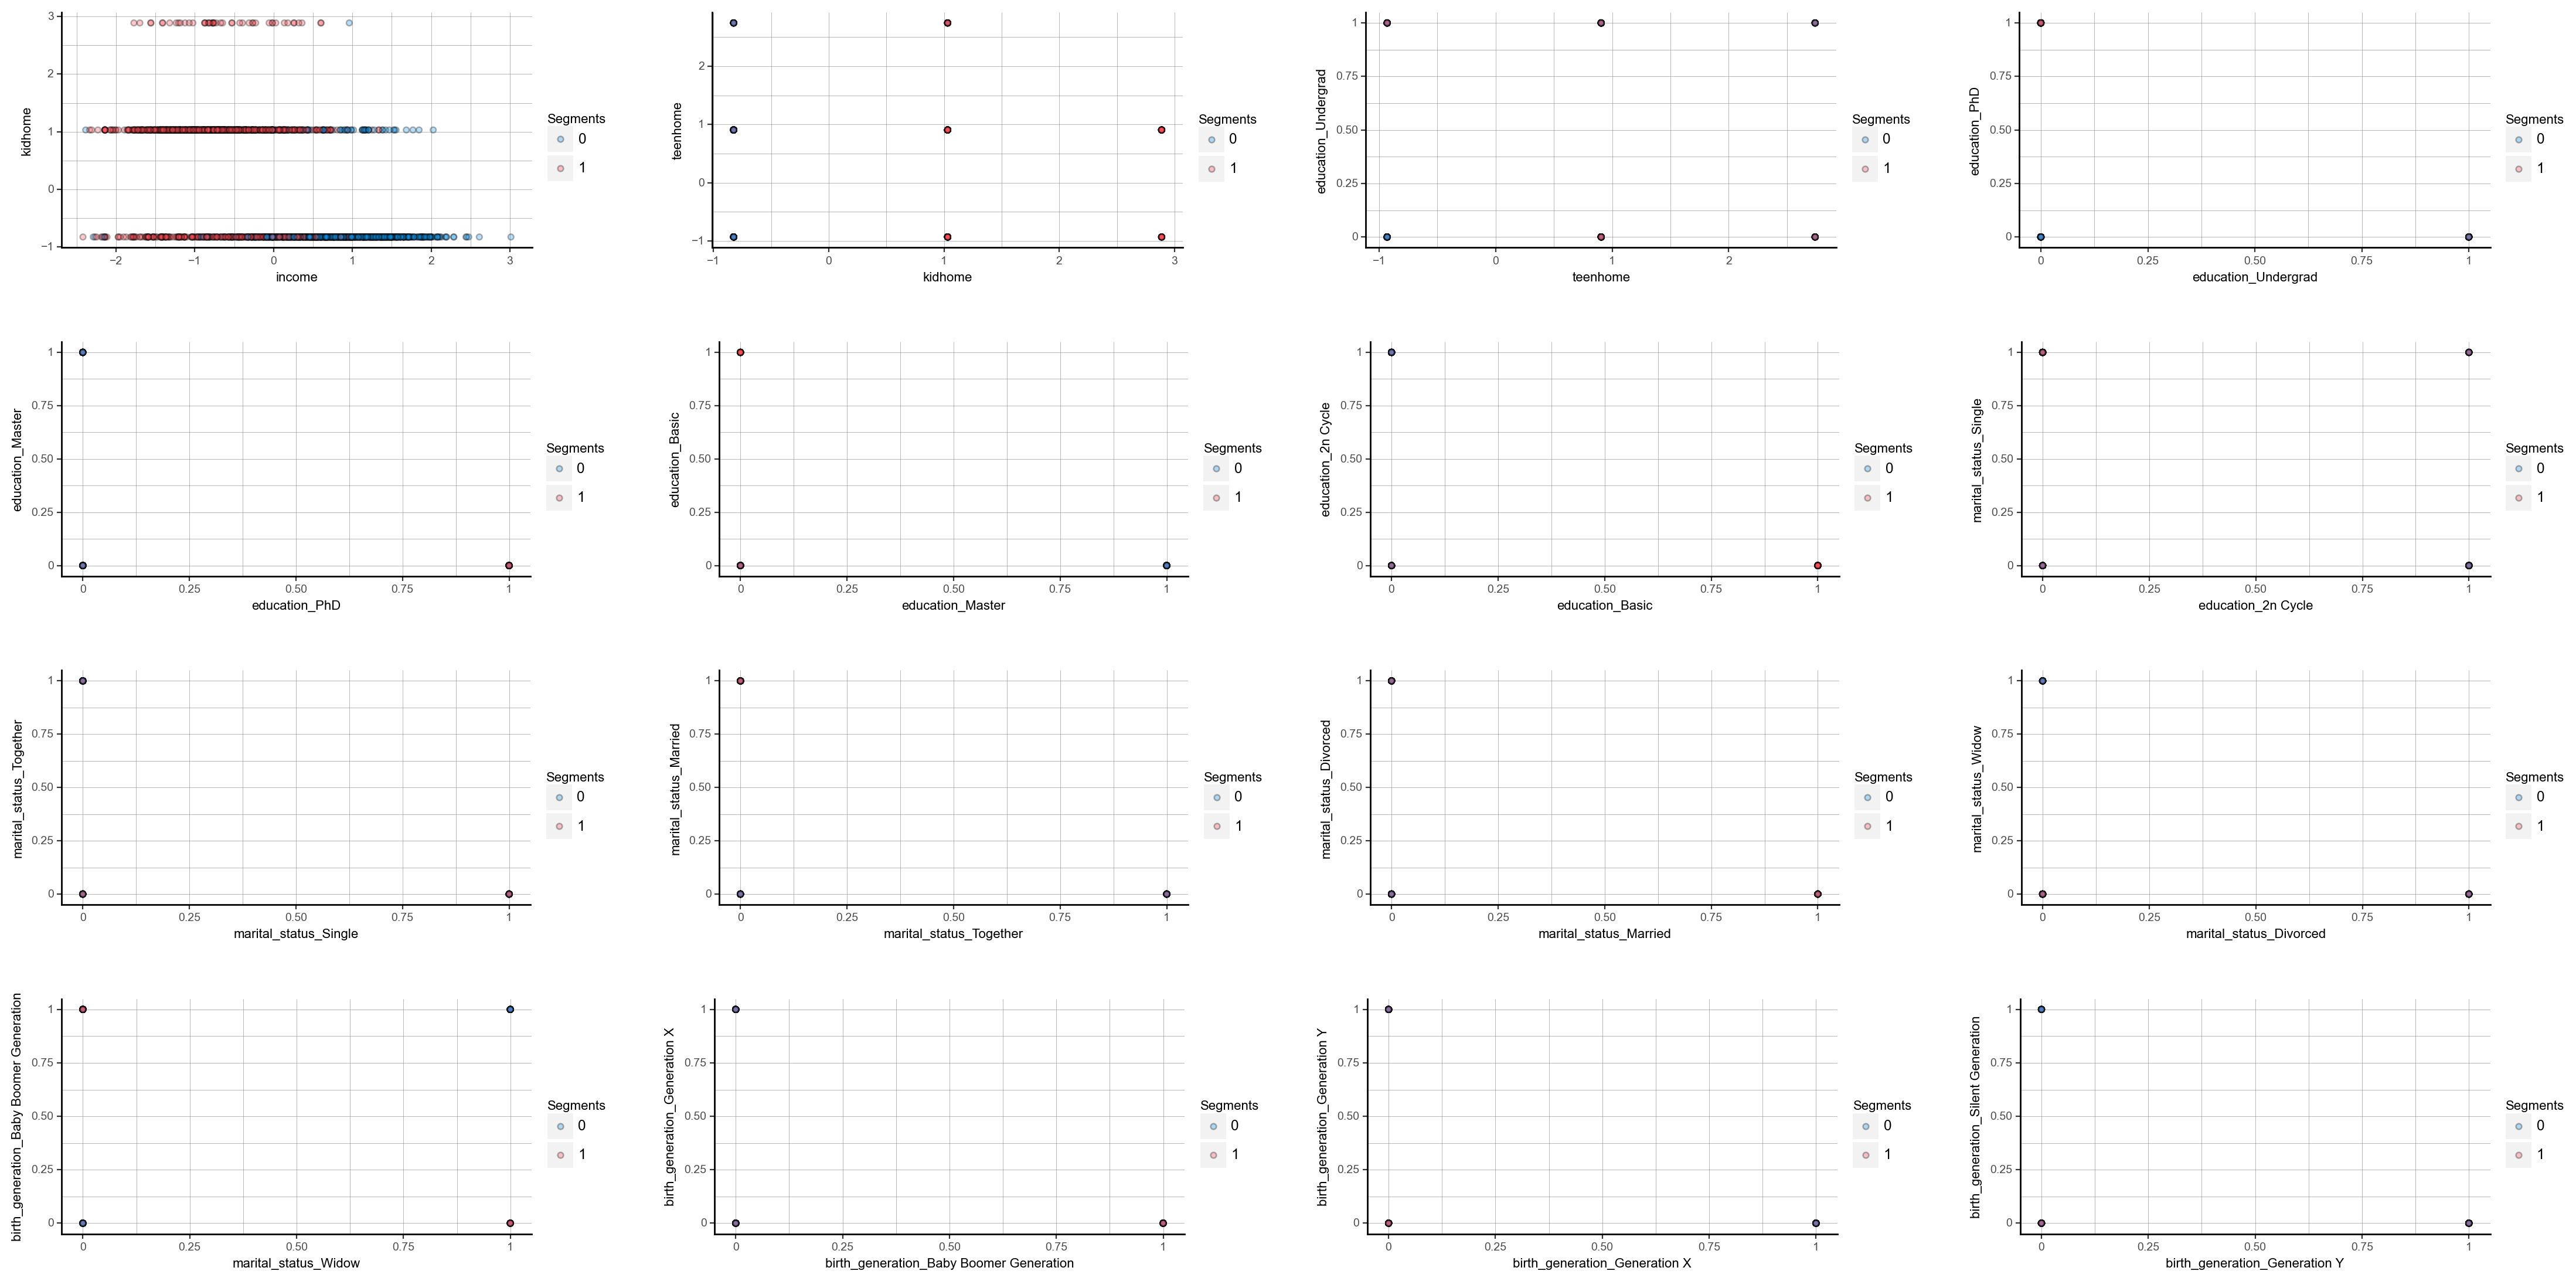

In [120]:
demographic_cols = demographic.columns.tolist()
demographic_patch_grid = make_ggplot_patch(
    demographic, 
    demographic_cols, 
)

demographic_patch_grid.show()

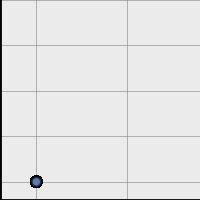

In [121]:
demographic_patch_grid.show().savefig('demographic_pattern_per_segment.png')

#### Purchasing Behavior

In [101]:
purchase = seg_df.select_columns(
    'mnt*', 
    'num*',
    'accepted*',
    'segments'
)

In [102]:
purchase_0 = purchase.filter_on('segments == 0')
purchase_1 = purchase.filter_on('segments == 1')

In [103]:
purchase_0.describe()

mnt_wines  mnt_fruits  mnt_meat_products  mnt_fish_products  \
count  881.000000  881.000000         881.000000         881.000000   
mean     0.907545    0.751696           0.888558           0.773142   
std      0.929614    1.215120           1.079230           1.182973   
min     -0.901993   -0.662483          -0.740242          -0.689133   
25%      0.207581   -0.160209           0.020601          -0.157118   
50%      0.765335    0.392293           0.612874           0.466623   
75%      1.533730    1.421957           1.519507           1.493961   
max      3.524437    4.335150           7.105096           4.062307   

       mnt_sweet_products  mnt_gold_prods  num_deals_purchases  \
count          881.000000      881.000000           881.000000   
mean             0.750403        0.621952            -0.186848   
std              1.215421        1.178130             0.934314   
min             -0.657713       -0.846501            -1.221851   
25%             -0.174125       -0.269965            -0.693861   
50%              0.382002        0.229699            -0.693861   
75%              1.494256        1.286680            -0.165872   
max              5.701478        6.110360             6.697993   

       num_web_purchases  num_catalog_purchases  num_store_purchases  \
count         881.000000             881.000000           881.000000   
mean            0.616553               0.949066             0.860248   
std             0.978614               0.902254             0.887462   
min            -1.476907              -0.943602            -1.790287   
25%            -0.034045               0.130319             0.058582   
50%             0.326670               0.846266             0.983017   
75%             1.048101               1.562213             1.599306   
max             8.262409               9.079660             2.215596   

       num_web_visits_month  accepted_cmp3  accepted_cmp4  accepted_cmp5  \
count            881.000000     881.000000     881.000000     881.000000   
mean              -0.681322       0.034317       0.227786       0.427495   
std                0.881469       1.054955       1.297988       1.491817   
min               -2.208728      -0.280226      -0.284863      -0.280226   
25%               -1.380129      -0.280226      -0.284863      -0.280226   
50%               -0.965830      -0.280226      -0.284863      -0.280226   
75%               -0.137231      -0.280226      -0.284863      -0.280226   
max                1.519967       3.568553       3.510463       3.568553   

       accepted_cmp1  accepted_cmp2  segments  
count     881.000000     881.000000     881.0  
mean        0.367408       0.158664       0.0  
std         1.474144       1.521866       0.0  
min        -0.262076      -0.116908       0.0  
25%        -0.262076      -0.116908       0.0  
50%        -0.262076      -0.116908       0.0  
75%        -0.262076      -0.116908       0.0  
max         3.815683       8.553752       0.0

In [104]:
purchase_1.describe()

mnt_wines   mnt_fruits  mnt_meat_products  mnt_fish_products  \
count  1344.000000  1344.000000        1344.000000        1344.000000   
mean     -0.594901    -0.492741          -0.582455          -0.506799   
std       0.442732     0.274970           0.190024           0.301016   
min      -0.904960    -0.662483          -0.753910          -0.689133   
25%      -0.872326    -0.637370          -0.712906          -0.652442   
50%      -0.801123    -0.587142          -0.660513          -0.615752   
75%      -0.474036    -0.461574          -0.507889          -0.468989   
max       2.355527     1.924231           0.398745           2.594681   

       mnt_sweet_products  mnt_gold_prods  num_deals_purchases  \
count         1344.000000     1344.000000          1344.000000   
mean            -0.491893       -0.407693             0.122480   
std              0.277923        0.571985             1.023147   
min             -0.657713       -0.846501            -1.221851   
25%             -0.657713       -0.750412            -0.693861   
50%             -0.585175       -0.615887            -0.165872   
75%             -0.464278       -0.308401             0.362118   
max              3.138458        4.188575             6.697993   

       num_web_purchases  num_catalog_purchases  num_store_purchases  \
count        1344.000000            1344.000000          1344.000000   
mean           -0.404154              -0.622119            -0.563898   
std             0.785103               0.380963             0.580517   
min            -1.476907              -0.943602            -1.790287   
25%            -1.116191              -0.943602            -0.865852   
50%            -0.755476              -0.585629            -0.865852   
75%            -0.034045              -0.585629            -0.249563   
max             2.490963               1.204240             1.907451   

       num_web_visits_month  accepted_cmp3  accepted_cmp4  accepted_cmp5  \
count           1344.000000    1344.000000    1344.000000   1.344000e+03   
mean               0.446611      -0.022495      -0.149315  -2.802257e-01   
std                0.802182       0.962399       0.704587   5.553181e-17   
min               -1.794428      -0.280226      -0.284863  -2.802257e-01   
25%               -0.137231      -0.280226      -0.284863  -2.802257e-01   
50%                0.691368      -0.280226      -0.284863  -2.802257e-01   
75%                1.105667      -0.280226      -0.284863  -2.802257e-01   
max                6.077260       3.568553       3.510463  -2.802257e-01   

       accepted_cmp1  accepted_cmp2  segments  
count    1344.000000    1344.000000    1344.0  
mean       -0.240838      -0.104005       1.0  
std         0.293629       0.334353       0.0  
min        -0.262076      -0.116908       1.0  
25%        -0.262076      -0.116908       1.0  
50%        -0.262076      -0.116908       1.0  
75%        -0.262076      -0.116908       1.0  
max         3.815683       8.553752       1.0

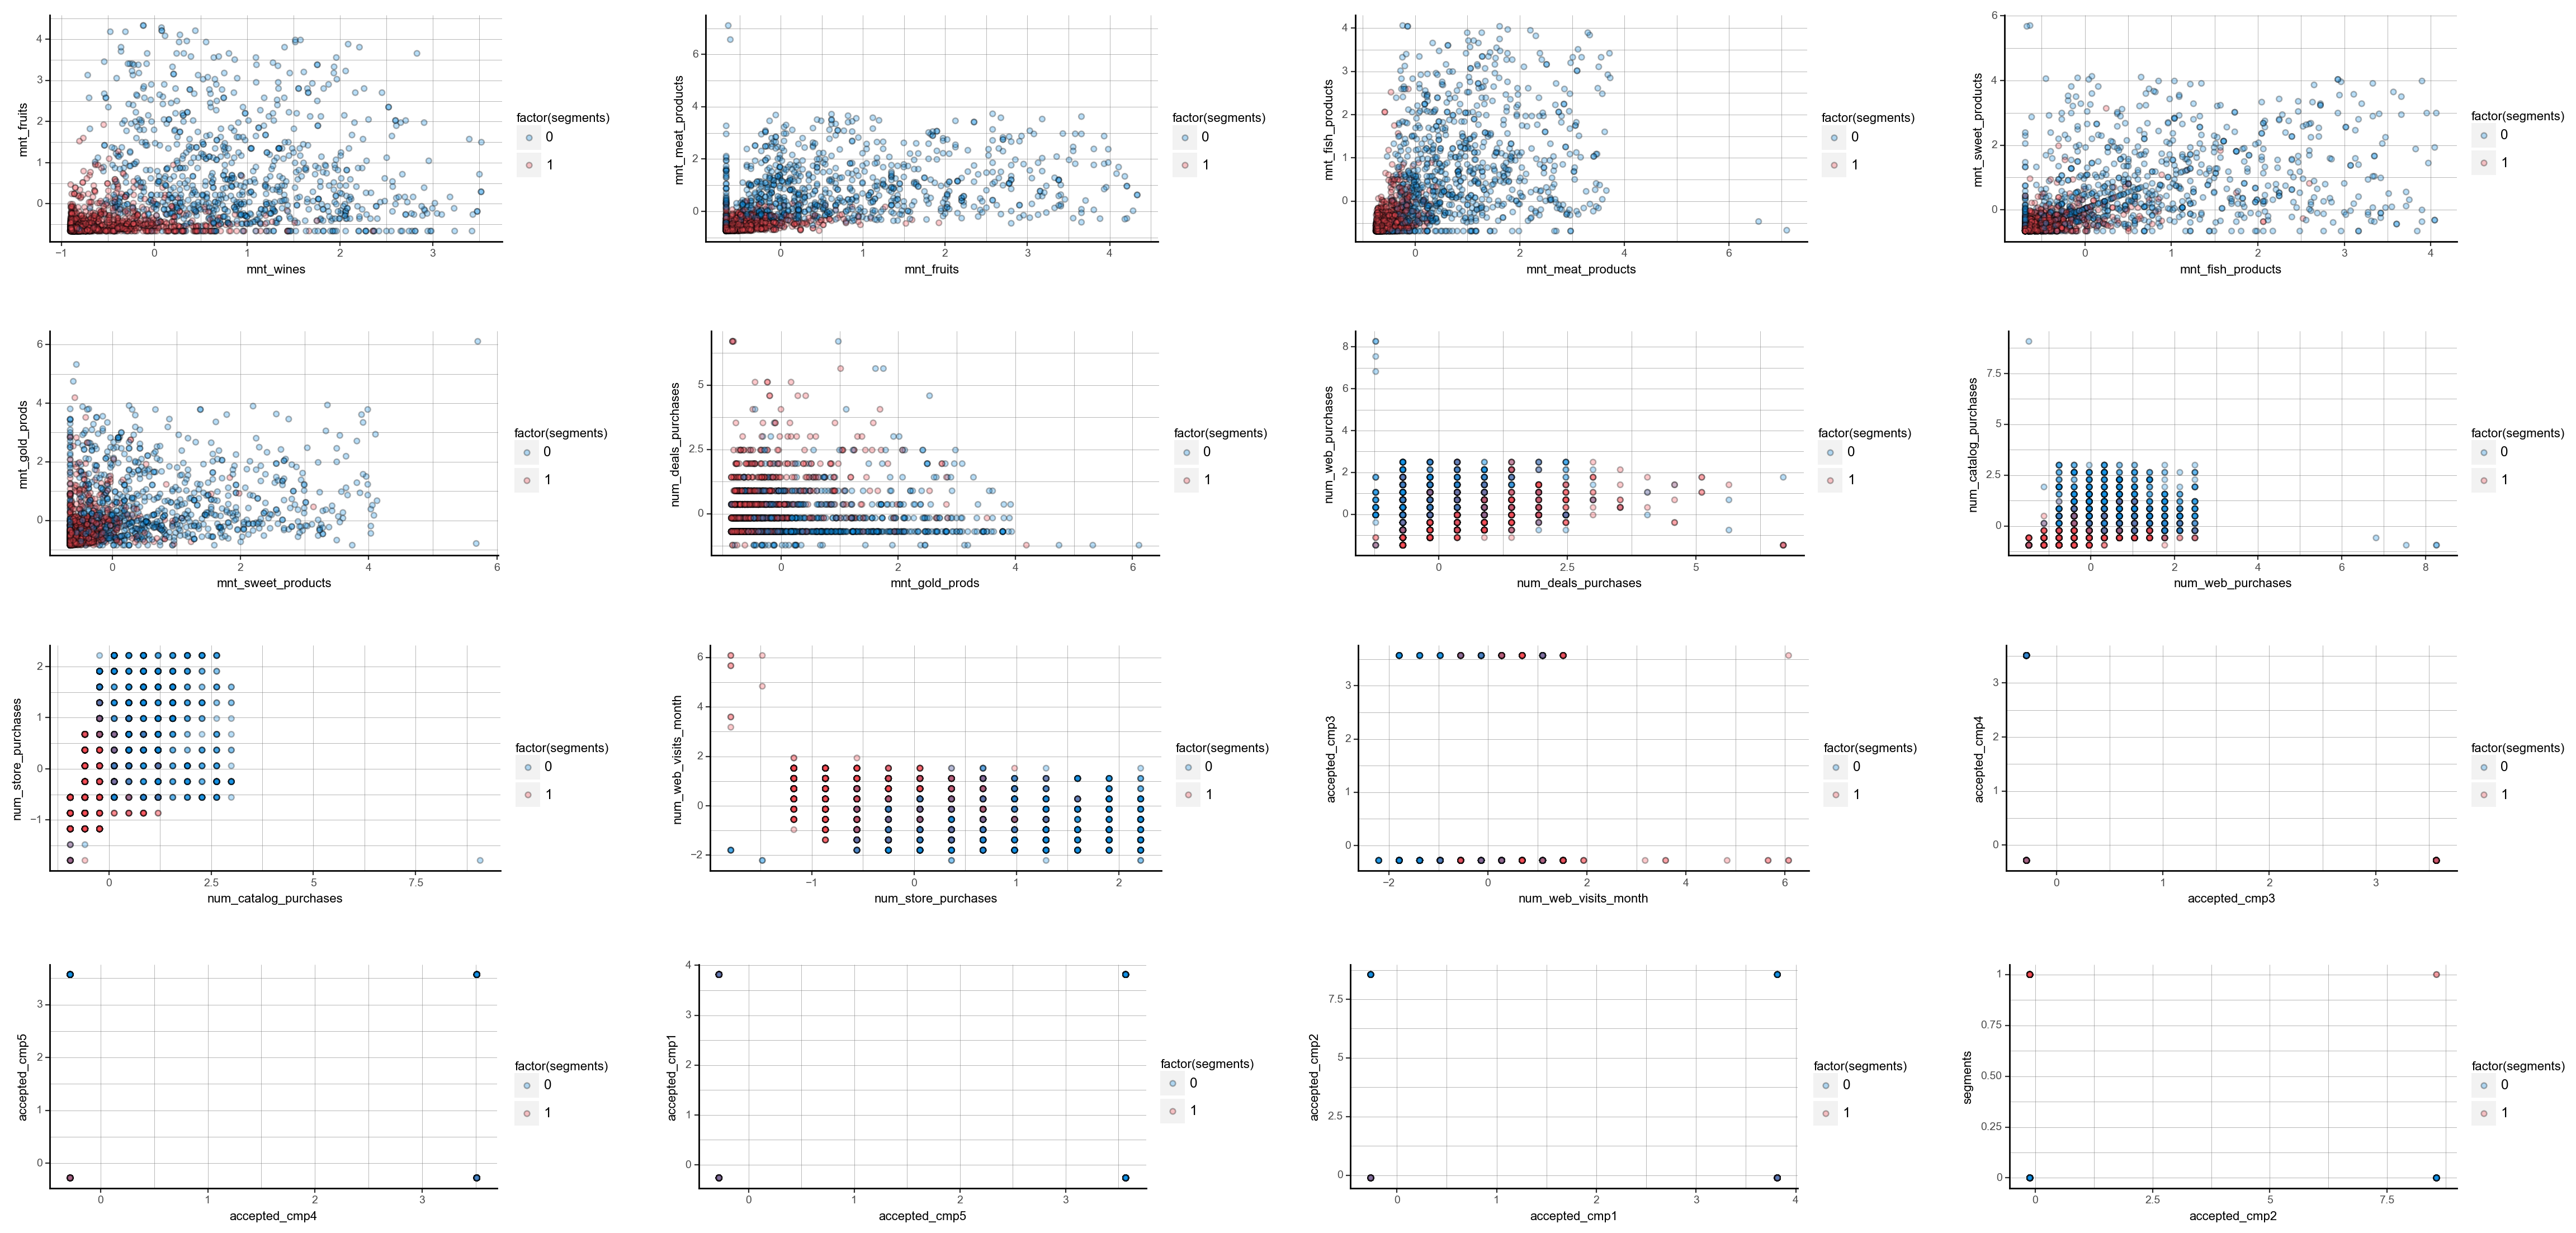

In [116]:
purchase_patch_grid = make_ggplot_patch(
    purchase, 
    purchase_cols, 
)

purchase_patch_grid.show()

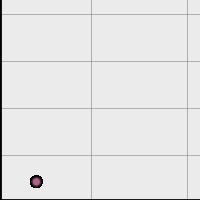

In [118]:
purchase_patch_grid.show().savefig('purchase_pattern_per_segment.png')